In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone
import vaex

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics
from utils.data import get_events, get_sections, process_df, export_dataframe_to_latex, load_df as load_df_inner
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

In [24]:
def compute_df_soc(df, nominal_Q, inplace=False):
    """
    Compute the State of Charge (SOC) of a battery.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        inplace (bool, optional): If True, the SOC values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed SOC values as a fraction of the nominal capacity.

    Notes:
        - The input DataFrame `df` is expected to contain a column named 'batt_Q' representing the battery charge.
        - The output SOC values are dimensionless fractions representing the battery's charge level relative to its nominal capacity.
        - If `inplace` is True, the computed SOC values are added as a new column 'batt_z' to the input DataFrame `df`.
    """
    SOC = df['batt_Q'].to_numpy() / nominal_Q

    if inplace:
        df['batt_z'] = SOC
    return SOC

def compute_df_capacity(df, nominal_Q, initial_SOC, inplace=False):
    """
    Compute the capacity of a battery based on cumulative integration of current over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        initial_SOC (float): Initial State of Charge (SOC) as a fraction of the nominal capacity.
        inplace (bool, optional): If True, the computed capacity values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed capacity values in Ampere-hours (Ah).

    Notes:
        - The input DataFrame `df` is expected to contain columns 'batt_i' for battery current and 't' for time.
        - The output capacity values represent the remaining battery capacity after cumulative integration of current over time.
        - The input parameter `initial_SOC` is a dimensionless fraction representing the initial battery charge relative to its nominal capacity.
        - If `inplace` is True, the computed capacity values are added as a new column 'batt_Q' to the input DataFrame `df`.
    """
    from scipy.integrate import cumulative_trapezoid as cumtrapz

    time_hours = df['t'] / 3600.0  # Converts time in seconds to time in hours
    Q = (nominal_Q * initial_SOC) - cumtrapz(df['batt_i'], time_hours, initial=0)  # units: Amper-hour

    if inplace:
        df['batt_Q'] = Q
    return Q

def load_df(filename, start, end, resample_rule, rename_columns, print_columns, iqr_threshold, cutoff_freq, sampling_rate, order, nominal_Q, initial_SOC):
    df = load_df_inner(
        filename=filename,
        start=start,
        end=end,
        resample_rule=resample_rule,
        rename_columns=rename_columns,
        print_columns=print_columns,
        iqr_threshold=iqr_threshold,
        cutoff_freq=cutoff_freq,
        sampling_rate=sampling_rate,
        order=order,
    )

    compute_df_capacity(df, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df, nominal_Q, inplace=True)

    return df

cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 0.99

Train size ≃ 51.14%
Test size ≃ 48.86%


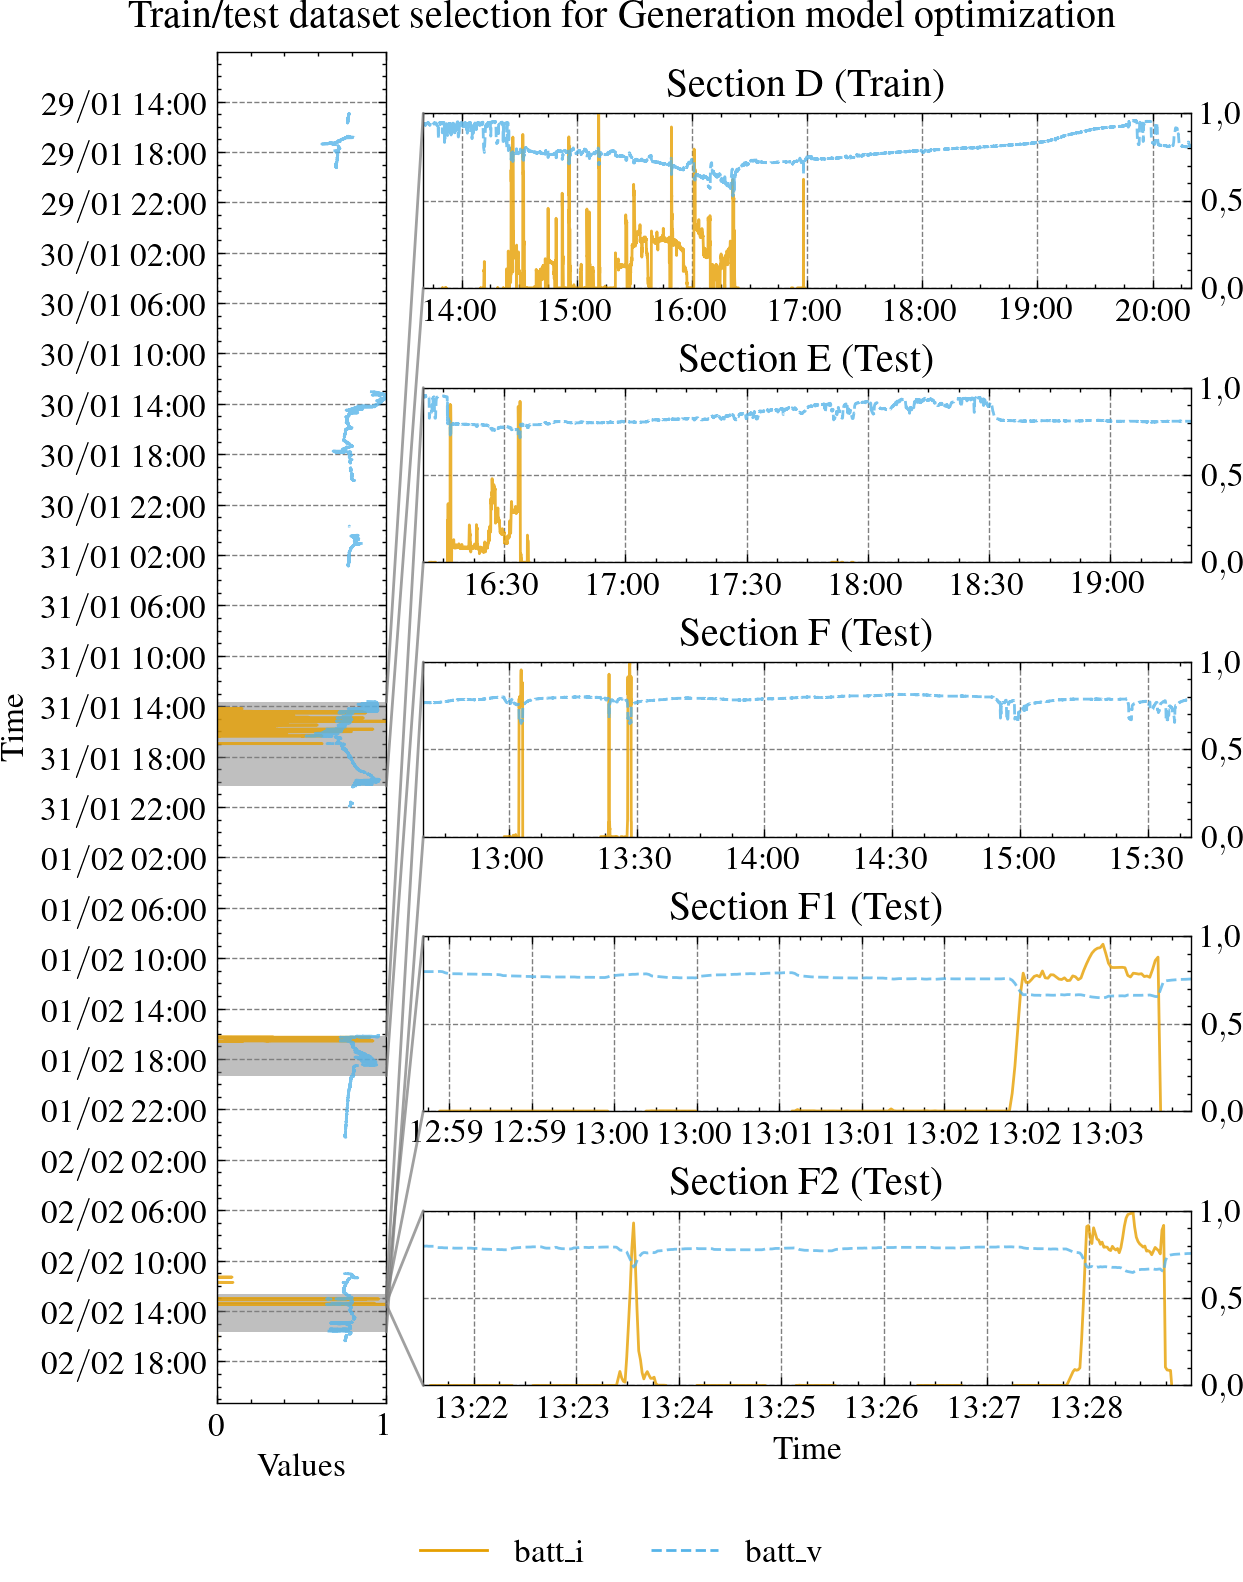

In [25]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
    # 'ESC Duty Cycle': 'pilot_d',
    # 'Motor Angular Speed': 'motor_w',
    # 'ESC Input Power': 'esc_p_in',
    # 'ESC Input Current': 'esc_i_in',
    # **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,5)},
    # **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,5)},
    # **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,5)},
    # **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,5)},
    # 'MPPTs Output Current': 'mppts_i_out',
    # 'PVs G': 'pv_g',
    # 'Solar POA': 'solar_poa',
    # 'Wind Speed': 'wind_v',
    # 'Air Temperature': 'air_t',
}
df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
    nominal_Q=nominal_Q,
    initial_SOC=initial_SOC
)

sections, tzinfo = get_sections()

# Customizing ranges:
# sections.loc['Section D', 'start'] = pd.Timestamp('2020-01-31 14:20:00')
# sections.loc['Section D', 'end'] = pd.Timestamp('2020-01-31 16:20:00')
# sections.loc['Section E', 'end'] = pd.Timestamp('2020-02-01 16:20:00')
sections.loc['Section F1'] = [pd.Timestamp('2020-02-02 12:58:50'), pd.Timestamp('2020-02-02 13:03:30')]
sections.loc['Section F2'] = [pd.Timestamp('2020-02-02 13:21:30'), pd.Timestamp('2020-02-02 13:29:00')]
sections = sections.loc[['Section D', 'Section E', 'Section F', 'Section F1', 'Section F2']]

# sections = sections.loc[['Section D', 'Section E', 'Section F']]
train_section_name = 'Section D'
train_test_sections = sections.reset_index().to_dict(orient='records')
train_section = sections.loc[sections.index == train_section_name].reset_index().to_dict(orient='records')[0]
test_sections = sections.loc[sections.index != train_section_name].reset_index().to_dict(orient='records')

train_size = 0
test_size = 0
for i in range(len(train_test_sections)):
    if train_test_sections[i]['name'] == train_section_name:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Train)'
        train_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size
    else:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Test)'
        test_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size


total_size = train_size+test_size
print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
        filename=None,#f'{latex_img_path}/battery_optimization_test_residuals_{col}.pdf',
        show_title=f'Train/test dataset selection for Generation model optimization',
        save_title=f'Dataset da embarcação durante o DSB de 2019',
        ncol=4,
        fig=plot_events_data(
            events=train_test_sections,
            df=df,
            column_names=['batt_i', 'batt_v'],
            normalize=True,
        )
    )


# Battery Equivalent Circuit Model


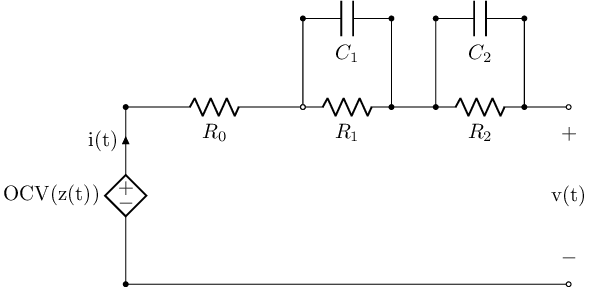

In [26]:
# !pip install lcapy zfitpy pyspice
# %pip install https://github.com/mph-/lcapy/archive/master.zip
# Open `tllocalmgr`, then `install circuitikz`, then `exit`, then `sudo texhash`
import lcapy as lca

circuit_draw_params = dict(
    # help_lines=1,
    # debug=True,
    draw_nodes=True,
    label_nodes=False,
    label_ids=True,
    label_values=False,
    cpt_size=1,
    node_spacing=3,
    scale=1,
    dpi=150,
)

circuit = lca.Circuit("""
E1 R0.1 0 2 0; down, l={OCV(z(t))}, i>={i(t)}
R0 .1 .2; right
R1 R0.2 .2; right=0.5
C1 .1 .2; right=0.5
W R1.1 C1.1; up=0.5
W R1.2 C1.2; up=0.5
W R1.2 R2.1; right=0.25
R2 .1 .2; right=0.5
C2 .1 .2; right=0.5
W R2.1 C2.1; up=0.5
W R2.2 C2.2; up=0.5
W R2.2 P1.1; right=0.25
P1 .1 0_2; down, v={v(t)}
W 0 0_2; right
;""")
circuit.draw(**circuit_draw_params)
circuit.draw(**circuit_draw_params, filename="/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/battery_model_2rc.png")


![](feZkCLr.png)

De acordo com [Mateo Basic](https://www.sciencedirect.com/science/article/pii/S2405896322003469), as seguintes equações representam o sistema da imagem acima, onde $z(t)$ é o estado de carga da bateria:

$$ \begin{aligned}
    \frac{dv_{C_{1}}(t) }{ dt } &=
        -\frac{ v_{C_{1}}(t) }{ R_{1} C_{1} }
        +\frac{ i(t) }{ C_{1} } \\
    \frac{ dv_{C_{0}}(t) }{ dt } &=
        \frac{ i(t) }{ C_{0} } \\
    v(t) &= 
        -v_{C_{0}}
        -v_{C_{1}}
        -R_{0} i(t)
\end{aligned} $$

O estado de carga ($z(t)$) pode ser definido como nas equações abaixo, onde $Q$ é a carga nominal da bateria, e $\eta$, a eficiência culombica:

$$ \begin{aligned}
    z(t) &= 
        z(t_{0}) 
        -\frac{1}{Q} \int_{t_{0}}^t \eta(t) i(t) dt \\
    \frac{dz(t)}{dt} &= 
        -\frac{\eta(t) i(t)}{Q}
\end{aligned} $$

Para que possam ser utilizadas os métodos de solução de sistemas no espaço de estados, podemos separar $VOC(z(t))$ em um modelo externo, considerando-o como uma entrada, deste modo, a função $VOC(z(t))$ pode ser um modelo caixa-preta.

In [27]:
import control as ct
from math import sqrt, pi

class Battery:
    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        # Params
        batt_R_1, batt_R_2, batt_R_3 = (
            params['batt_R_1'],
            params['batt_R_2'],
            params['batt_R_3'],
        )

        # Input Initial Conditions
        batt_z_0 = X0['batt_z']

        # Inputs
        batt_i = U0[0]  # Battery current [A]

        # Initial condition equations
        batt_v_C_1_0 = batt_i * batt_R_1
        batt_v_C_2_0 = batt_i * batt_R_2
        batt_v_C_3_0 = batt_i * batt_R_3

        return np.array([batt_z_0, batt_v_C_1_0, batt_v_C_2_0, batt_v_C_3_0])

    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Params
        batt_eta, batt_Q, batt_R_1, batt_tau_1, batt_R_2, batt_tau_2, batt_R_3, batt_tau_3 = (
            params['batt_eta'],
            params['batt_Q'],
            params['batt_R_1'],
            params['batt_tau_1'],
            params['batt_R_2'],
            params['batt_tau_2'],
            params['batt_R_3'],
            params['batt_tau_3'],
        )

        # Inputs
        batt_i = u[0]  # Battery current [A]

        # States
        # batt_z = x[0]  # battery State Of Charge [unitless]
        batt_v_C_1 = x[1]  # battery voltage through the internal serie-parallel resistance [V]
        batt_v_C_2 = x[2]  # battery voltage through the internal serie-parallel resistance [V]
        batt_v_C_3 = x[3]  # battery voltage through the internal serie-parallel resistance [V]

        # System of differential equations
        d_batt_z = -batt_eta * batt_i / batt_Q
        d_batt_v_C_1 = (-batt_v_C_1 + batt_i * batt_R_1) / batt_tau_1
        d_batt_v_C_2 = (-batt_v_C_2 + batt_i * batt_R_2) / batt_tau_2
        d_batt_v_C_3 = (-batt_v_C_3 + batt_i * batt_R_3) / batt_tau_3

        return np.array([d_batt_z, d_batt_v_C_1, d_batt_v_C_2, d_batt_v_C_3])

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Params
        batt_R_0, batt_k_V_OC_coeffs = (
            params['batt_R_0'],
            params['batt_k_V_OC_coeffs'],
        )

        # Inputs
        batt_i = u[0]  # Battery current [A]

        # States
        batt_z = x[0]  # battery State Of Charge [unitless]
        batt_v_C_1 = x[1]  # battery voltage through the internal serie-parallel resistance [V]
        batt_v_C_2 = x[2]  # battery voltage through the internal serie-parallel resistance [V]
        batt_v_C_3 = x[3]  # battery voltage through the internal serie-parallel resistance [V]

        # Output equations
        batt_ocv = np.polynomial.Polynomial(batt_k_V_OC_coeffs)(batt_z)
        batt_v = batt_ocv - batt_R_0 * batt_i - batt_v_C_1 - batt_v_C_2 - batt_v_C_3

        return np.array([batt_v, batt_z, batt_ocv])


    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='battery',
            states=('batt_z', 'd_batt_v_C_1', 'd_batt_v_C_2', 'batt_v_C_3'),
            inputs=('batt_i',),
            outputs=('batt_v', 'batt_z', 'batt_ocv'),
            params=params,
        )

Battery.build({})

<NonlinearIOSystem:battery:['batt_i']->['batt_v', 'batt_z', 'batt_ocv']>

array([  31.50231386,   35.10920712, -143.93021665,  360.36031983,
       -489.66157617,  339.79072398,  -93.87254902])

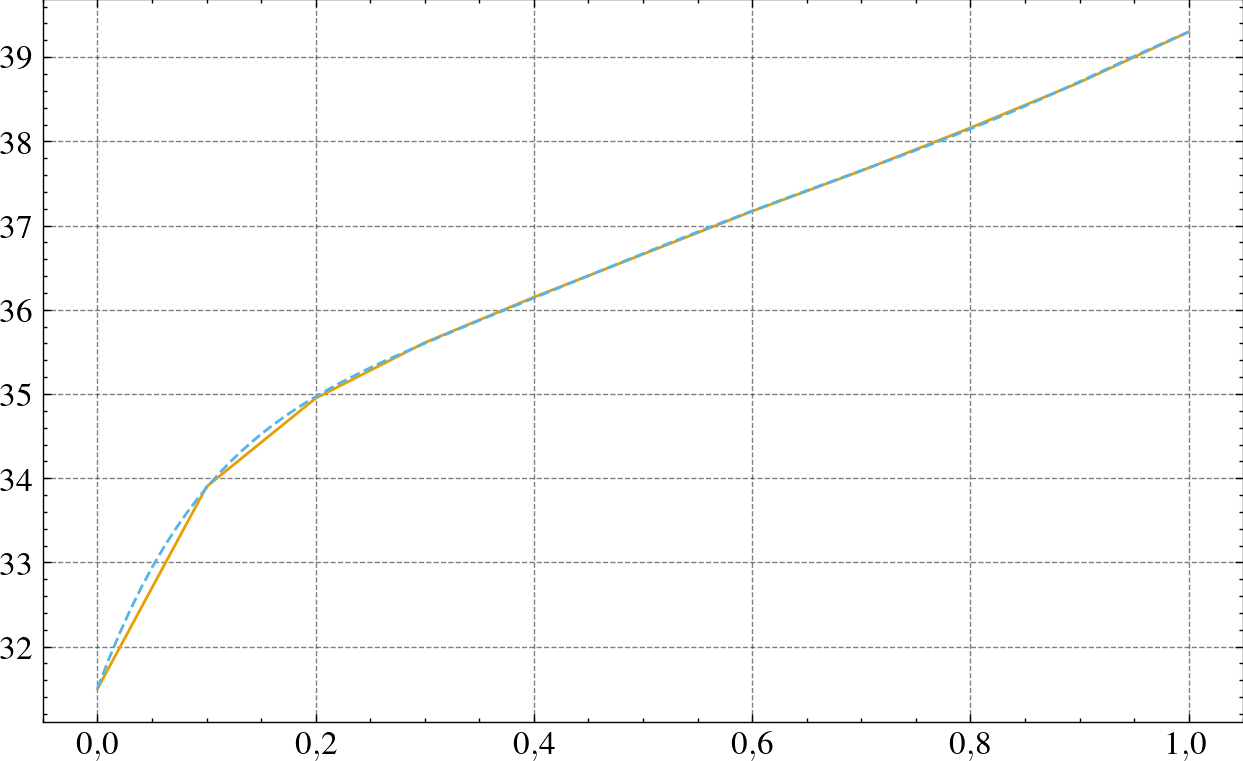

In [28]:
plt.figure()

# From: https://imgv2-2-f.scribdassets.com/img/document/682244176/original/0a169c4659/1730632177?v=1
v = np.array([13.1, 12.9, 12.72, 12.55, 12.39, 12.22, 12.05, 11.87, 11.65, 11.3, 10.5]) * 3
z = np.array([1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0])
plt.plot(z, v)

deg = 6
batt_k_V_OC_coeffs = np.polynomial.Polynomial.fit(z, v, deg, [0, 1]).convert().coef
display(batt_k_V_OC_coeffs)

z = np.linspace(0, 1, 100)
y_ref = np.polynomial.Polynomial(batt_k_V_OC_coeffs)(z)
plt.plot(z, y_ref)
plt.show()

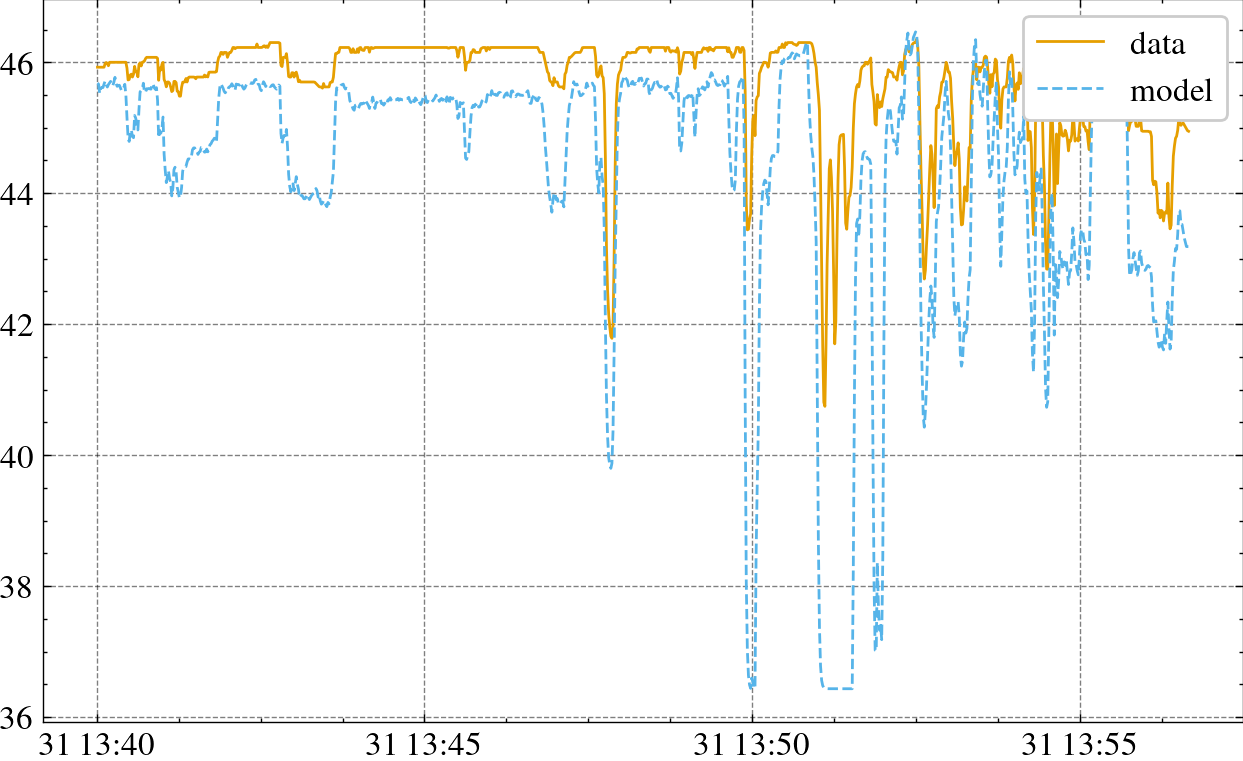

In [29]:
batt_name = 'D35'
cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 1
nominal_voltage = series_cells * cell_voltage

battery_params = {
    'batt_eta': 1,
    'batt_Q': cell_amps_hour * 3600,
    'batt_R_0': 0.1,
    'batt_R_1': 0.5,
    'batt_tau_1': 1,
    'batt_R_2': 1e-3,
    'batt_tau_2': 1,
    'batt_R_3': 1e-3,
    'batt_tau_3': 1,
    'batt_k_V_OC_coeffs': batt_k_V_OC_coeffs,
}

# Select the optimization data
data_cols = ['batt_v']
input_cols = ['batt_i']

df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols][:1000]

# Time array
T = df_train['t'].to_numpy()

# Inputs
U = df_train[['batt_i']].to_numpy().T

# Model
battery = Battery.build(battery_params)

# Initial state
X0 = Battery.initial_state(X0={'batt_z': 0.4}, U0=U[:,0], params=battery_params)

# Simulation
res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]

plt.plot(df_train.index, df_train['batt_v'], label='data')
plt.plot(df_train.index, ydata['batt_v'], label='model')
plt.legend(loc='upper right')
plt.show()

# Sensitivity Analysis

In [30]:
from SALib import ProblemSpec

import warnings
warnings.filterwarnings("ignore")


def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Battery.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()


def battery_sensitivity_analysis_discharge_case(
    T: np.array,
    params_bounds: dict,
    discharge_rate: float,
    initial_SOC: float,
    do_plot=True,
    do_display=True
):
    # discharge_rate: 10 means it's dicharging at 10C, -5 means it's charging at 5C
    discharge_current = nominal_Q * discharge_rate

    model_params = battery_params
    model = Battery
    model_tmp = model.build({})

    sp = ProblemSpec({
        "names":  list(params_bounds.keys()),
        "bounds": [(p['min'], p['max']) for p in params_bounds.values()],
        "outputs": model_tmp.output_labels,
        'dists': [p['dist'] for p in params_bounds.values()],
        'groups': [p.get('group') or name for name, p in params_bounds.items()],
        "seed": 42,
    })

    # Initial state
    X0 = np.zeros(model_tmp.nstates)
    X0[model_tmp.state_labels.index('batt_z')] = initial_SOC
    X0[battery.state_index['d_batt_v_C_1']] = df_train['batt_i'][0] * battery_params['batt_R_1']
    X0[battery.state_index['d_batt_v_C_2']] = df_train['batt_i'][0] * battery_params['batt_R_2']

    # Input data
    U = np.empty([model_tmp.ninputs, len(T)]) * np.nan # nan to force us to define every input
    U[model_tmp.input_labels.index('batt_i')] = discharge_current

    df_sa = sensitivity_analysis(
        T=T,
        U=U,
        X0=X0,
        model_function=model_function,
        model_class=model,
        model_params=model_params,
        problem=sp,
        sample_size=2**12*len(sp["groups"]),
        nprocs=32,
        analyze_kwargs=dict(
            parallel=True,
            n_processors=12
        ),
    )
    if do_display: display(df_sa)

    df_sac = consolidate_sa_results(df_sa)
    if do_display: display(df_sac.dropna())
    if do_display: display(df_sac.dropna().pivot(index=['Output', 'Factor'], columns='Order', values=['Mean', 'Mean Conf']))

    if do_plot:
        for output in df_sa['output'].unique():
            fig_save_and_show(
                # f'{latex_img_path}/battery_sensibility_analysis_time.pdf',
                None,
                f'Sensibilidade da saída {output} do modelo da bateria aos seus parâmetros no tempo',
                f'Sensitivity of the battery model\noutput {output} to parameters over time',
                fig=plot_sensitivity_analysis(df_sa, output),
            )

        for output in df_sa['output'].unique():
            fig_save_and_show(
                # f'{latex_img_path}/battery_sensibility_analysis_steady_state.pdf',
                None,
                f'Sensibilidade da saída {output} do modelo da bateria aos seus parâmetros no tempo ',
                f'Sensitivity of the battery model\noutput {output} to parameters over time',
                fig=plot_sensitivity_heatmaps(df_sa, output),
            )

        fig_save_and_show(
            # f'{latex_img_path}/battery_sensibility_analysis_steady_state_second_order.pdf',
            None,
            f'Sensibilidade das saídas do modelo da bateria aos seus parâmetros em regime permanente ',
            f'Second-Order Sensitivity Analysis for steady state',
            fig=plot_sensitivity_analysis_second_order(df_sa),
        )

    return df_sa, df_sac


params_bounds = {
    'batt_R_0': dict(min=1e-6, max=1, dist='logunif', group=None),
    'batt_R_1': dict(min=1e-6, max=1, dist='logunif', group=None),
    'batt_C_1': dict(min=1, max=1e3, dist='logunif', group=None),
    'batt_R_2': dict(min=1e-6, max=1e3, dist='logunif', group=None),
    'batt_C_2': dict(min=1e3, max=1e9, dist='logunif', group=None),
    'batt_eta': dict(min=0.1, max=1, dist='unif', group=None),
}
n_coeffs = 5
for i in range(0, n_coeffs):
    params_bounds[f'batt_ocv_coeff_{i}'] = dict(min=-100, max=100, dist='logunif', group='batt_k_V_OC_coeffs')

display(params_bounds)

{'batt_R_0': {'min': 1e-06, 'max': 1, 'dist': 'logunif', 'group': None},
 'batt_R_1': {'min': 1e-06, 'max': 1, 'dist': 'logunif', 'group': None},
 'batt_C_1': {'min': 1, 'max': 1000.0, 'dist': 'logunif', 'group': None},
 'batt_R_2': {'min': 1e-06, 'max': 1000.0, 'dist': 'logunif', 'group': None},
 'batt_C_2': {'min': 1000.0,
  'max': 1000000000.0,
  'dist': 'logunif',
  'group': None},
 'batt_eta': {'min': 0.1, 'max': 1, 'dist': 'unif', 'group': None},
 'batt_ocv_coeff_0': {'min': -100,
  'max': 100,
  'dist': 'logunif',
  'group': 'batt_k_V_OC_coeffs'},
 'batt_ocv_coeff_1': {'min': -100,
  'max': 100,
  'dist': 'logunif',
  'group': 'batt_k_V_OC_coeffs'},
 'batt_ocv_coeff_2': {'min': -100,
  'max': 100,
  'dist': 'logunif',
  'group': 'batt_k_V_OC_coeffs'},
 'batt_ocv_coeff_3': {'min': -100,
  'max': 100,
  'dist': 'logunif',
  'group': 'batt_k_V_OC_coeffs'},
 'batt_ocv_coeff_4': {'min': -100,
  'max': 100,
  'dist': 'logunif',
  'group': 'batt_k_V_OC_coeffs'}}

In [31]:
# %%time
# ## BATTERY SENSIVITY ANALYSIS: DISCHARGE @ 1C

# # Since the test will take an hour, and it's quite monotonous, we can have just a few samples
# df_sa, df_sac = battery_sensitivity_analysis_discharge_case(
#     T=np.linspace(0, 3600, 11, endpoint=True),
#     params_bounds=params_bounds,
#     discharge_rate=1,
#     initial_SOC=1,
#     do_plot=True,
#     do_display=True,
# )

In [32]:
# %%time
# ## BATTERY SENSIVITY ANALYSIS: CHARGE @ 1C

# df_sa, df_sac = battery_sensitivity_analysis_discharge_case(
#     T=np.linspace(0, 3600, 11, endpoint=True),
#     params_bounds=params_bounds,
#     discharge_rate=-1,
#     initial_SOC=0,
#     do_plot=True,
#     do_display=True,
# )

In [33]:
# %%time
# ## BATTERY SENSIVITY ANALYSIS: HIGH CURRENT PEAKS

# def battery_sensitivity_analysis_arbitrary_current_signal(
#     T: np.array,
#     current_signal: np.array,
#     params_bounds: dict,
#     discharge_rate: float,
#     initial_SOC: float,
#     do_plot=True,
#     do_display=True
# ):
#     model_params = battery_params
#     model = Battery
#     model_tmp = model.build({})

#     sp = ProblemSpec({
#         "names":  list(params_bounds.keys()),
#         "bounds": [(p['min'], p['max']) for p in params_bounds.values()],
#         "outputs": model_tmp.output_labels,
#         'dists': [p['dist'] for p in params_bounds.values()],
#         'groups': [p.get('group') or name for name, p in params_bounds.items()],
#         "seed": 42,
#     })

#     # # Initial state
#     X0 = np.zeros(model_tmp.nstates)
#     X0[model_tmp.state_labels.index('batt_z')] = initial_SOC

#     # # If we are discharging
#     U = np.empty([model_tmp.ninputs, len(T)]) * np.nan # nan to force us to define every input
#     U[model_tmp.input_labels.index('batt_i')] = current_signal

#     df_sa = sensitivity_analysis(
#         T=T,
#         U=U,
#         X0=X0,
#         model_function=model_function,
#         model_class=model,
#         model_params=model_params,
#         problem=sp,
#         sample_size=2**12*len(sp["groups"]),
#         nprocs=32,
#         analyze_kwargs=dict(
#             parallel=False,
#             n_processors=4
#         ),
#     )
#     if do_display: display(df_sa)

#     df_sac = consolidate_sa_results(df_sa)
#     if do_display: display(df_sac.dropna())
#     if do_display: display(df_sac.dropna().pivot(index=['Output', 'Factor'], columns='Order', values=['Mean', 'Mean Conf']))

#     if do_plot:
#         for output in df_sa['output'].unique():
#             fig_save_and_show(
#                 # f'{latex_img_path}/battery_sensibility_analysis_time.pdf',
#                 None,
#                 f'Sensibilidade da saída {output} do modelo da bateria aos seus parâmetros no tempo',
#                 f'Sensitivity of the battery model\noutput {output} to parameters over time',
#                 fig=plot_sensitivity_analysis(df_sa, output),
#             )

#         for output in df_sa['output'].unique():
#             fig_save_and_show(
#                 # f'{latex_img_path}/battery_sensibility_analysis_steady_state.pdf',
#                 None,
#                 f'Sensibilidade da saída {output} do modelo da bateria aos seus parâmetros no tempo ',
#                 f'Sensitivity of the battery model\noutput {output} to parameters over time',
#                 fig=plot_sensitivity_heatmaps(df_sa, output),
#             )

#         fig_save_and_show(
#             # f'{latex_img_path}/battery_sensibility_analysis_steady_state_second_order.pdf',
#             None,
#             f'Sensibilidade das saídas do modelo da bateria aos seus parâmetros em regime permanente ',
#             f'Second-Order Sensitivity Analysis for steady state',
#             fig=plot_sensitivity_analysis_second_order(df_sa),
#         )

#     return df_sa, df_sac

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import signal

# T = np.linspace(0, 100, 101, endpoint=True)
# peak = 100
# frequency = 0.02
# duty_cycle = 0.25
# phase = - np.pi / 2
# batt_i = (0.5 + signal.square(phase + 2 * np.pi * frequency * T, duty=duty_cycle) / 2) * peak

# plt.plot(T, batt_i)
# plt.xlabel("Time [s]")
# plt.ylabel("Current [A]")
# plt.suptitle("Battery current over time")
# plt.grid(True)
# plt.show()

# df_sa, df_sac = battery_sensitivity_analysis_arbitrary_current_signal(
#     T=T,
#     current_signal=batt_i,
#     params_bounds=params_bounds,
#     discharge_rate=-1,
#     initial_SOC=1,
#     do_plot=True,
#     do_display=True,
# )

# Optimization

In [34]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Battery.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

In [35]:
# train_section['start'] = pd.Timestamp(year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo).tz_convert(None)
# train_section['end'] = pd.Timestamp(year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo).tz_convert(None)

In [36]:
def estimate_polynomial_coefficient_bounds(x_interval, y_bounds, degree, grid_points=1000):
    """
    Estimate bounds for each coefficient a_j (j = 0, ..., degree) of a polynomial
      p(x) = a_0 + a_1*x + ... + a_degree*x^degree
    subject to:
      y_min <= p(x) <= y_max  for all x in [x_min, x_max].

    The "for all x" constraint is approximated by enforcing the constraints on a dense grid.

    Parameters:
        x_interval : tuple (x_min, x_max)
        y_bounds   : tuple (y_min, y_max)
        degree     : int, degree of the polynomial (there are degree+1 coefficients)
        grid_points: int, number of grid points in [x_min, x_max] for discretization.

    Returns:
        bounds: list of tuples [(a_0_min, a_0_max), (a_1_min, a_1_max), ...]
    """
    from scipy.optimize import linprog

    x_min, x_max = x_interval
    y_min, y_max = y_bounds

    # Create a dense grid on the x interval.
    x_grid = np.linspace(x_min, x_max, grid_points)
    M = grid_points

    # Build the design matrix: each row corresponds to an x value.
    # Each row is [1, x, x^2, ..., x^degree]
    X = np.vstack([x_grid**i for i in range(degree + 1)]).T  # shape: (M, degree+1)

    # Set up inequality constraints.
    # For each x in x_grid, we require:
    #    a_0 + a_1*x + ... + a_degree*x^degree <= y_max   and
    #   -a_0 - a_1*x - ... - a_degree*x^degree <= -y_min  (i.e. p(x) >= y_min)
    A_upper = X          # p(x) <= y_max
    A_lower = -X         # -p(x) <= -y_min
    A_ub = np.vstack([A_upper, A_lower])  # Combined constraint matrix
    b_upper = np.full(M, y_max)
    b_lower = np.full(M, -y_min)
    b_ub = np.concatenate([b_upper, b_lower])

    # Prepare a list to hold the computed bounds.
    bounds_list = []

    # For each coefficient index j, solve two LPs: one to maximize a_j, one to minimize a_j.
    for j in range(degree + 1):
        # --- Maximize a_j:  maximize a_j  <=> minimize -a_j ---
        # Objective: minimize c^T a, where c[j] = -1 and all other entries are 0.
        c_max = np.zeros(degree + 1)
        c_max[j] = -1  # maximize a_j by minimizing -a_j.
        res_max = linprog(c=c_max, A_ub=A_ub, b_ub=b_ub,
                          bounds=[(None, None)] * (degree + 1), method='highs')
        if not res_max.success:
            raise RuntimeError(f"LP maximizing coefficient a_{j} failed: {res_max.message}")
        a_j_max = res_max.x[j]

        # --- Minimize a_j: objective is to minimize a_j ---
        c_min = np.zeros(degree + 1)
        c_min[j] = 1
        res_min = linprog(c=c_min, A_ub=A_ub, b_ub=b_ub,
                          bounds=[(None, None)] * (degree + 1), method='highs')
        if not res_min.success:
            raise RuntimeError(f"LP minimizing coefficient a_{j} failed: {res_min.message}")
        a_j_min = res_min.x[j]

        bounds_list.append((a_j_min, a_j_max))

    return bounds_list

n_coeffs = 2
coeff_bounds = estimate_polynomial_coefficient_bounds(x_interval=(0, 1), y_bounds=(20, 60), degree=(n_coeffs-1))
coeff_bounds

In [37]:
batt_k_V_OC_coeffs

array([  31.50231386,   35.10920712, -143.93021665,  360.36031983,
       -489.66157617,  339.79072398,  -93.87254902])

In [38]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft, fftfreq
from scipy.signal import find_peaks

# Compute sampling frequency (assuming uniform timestamps)
time_diff = np.diff(df_train.index).astype('timedelta64[s]').astype(float)
sampling_rate = 1 / np.mean(time_diff)  # Average sample rate in Hz

# Perform FFT on voltage data
voltage = df_train["batt_v"].values
n = len(voltage)
freqs = fftfreq(n, d=1/sampling_rate)  # Frequency bins
fft_magnitude = np.abs(fft(voltage))  # Magnitude spectrum

# Find frequency peaks in the FFT magnitude
freq_peaks, freq_properties = find_peaks(fft_magnitude[:n//2], height=np.mean(fft_magnitude))

# Sort and get the top 5 peaks
top_5_freq_peaks = sorted(zip(freq_peaks, fft_magnitude[freq_peaks]), key=lambda x: x[1], reverse=True)[:5]

# Convert indices to actual frequency values
top_5_freqs = [(freqs[idx], mag) for idx, mag in top_5_freq_peaks]

# Print results
for idx, (freq, mag) in enumerate(top_5_freqs, 1):
    print(f"Peak {idx}: Frequency {freq:.4f} Hz (Period {1/freq:.2f} s), Magnitude {mag:.2f}")

top_5_freqs = np.array(top_5_freqs)

Peak 1: Frequency 0.0100 Hz (Period 100.00 s), Magnitude 225.91
Peak 2: Frequency 0.0040 Hz (Period 250.00 s), Magnitude 118.96
Peak 3: Frequency 0.0140 Hz (Period 71.43 s), Magnitude 110.93
Peak 4: Frequency 0.0160 Hz (Period 62.50 s), Magnitude 99.65
Peak 5: Frequency 0.0250 Hz (Period 40.00 s), Magnitude 97.14


In [39]:
periods = 1/top_5_freqs[:,0]
mags = top_5_freqs[:,1]
mags = mags / mags.max()

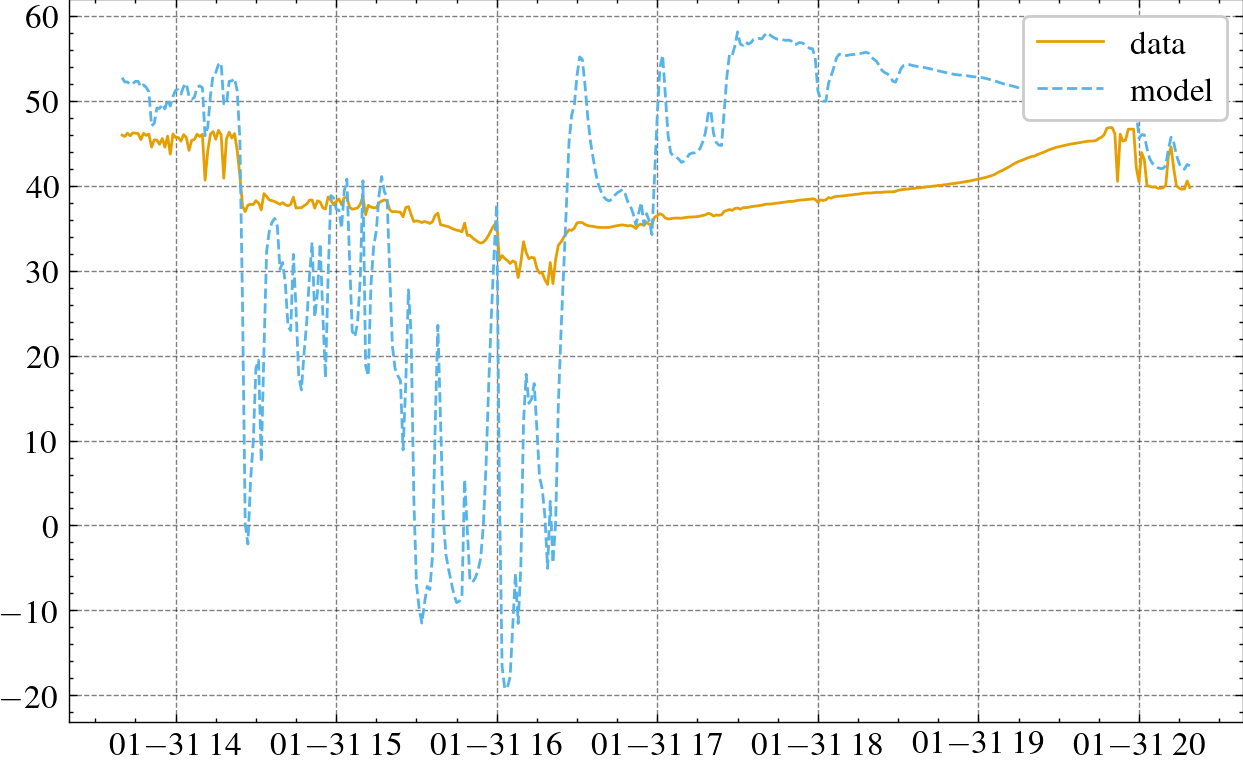

In [40]:
k = 0.1

battery_params['batt_R_0'] = 10*series_cells * 0.003 # from: http://raetech.com.sg/optima_yellow_specs.html
battery_params['batt_R_1'] = mags[1]*k
battery_params['batt_R_2'] = mags[2]#*k
battery_params['batt_R_3'] = mags[3]#*k
battery_params['batt_tau_1'] = periods[1]
battery_params['batt_tau_2'] = periods[2]
battery_params['batt_tau_3'] = periods[3]
# battery_params['batt_k_V_OC_coeffs'] = np.array([0])

df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols].resample('1min').mean().interpolate(method='time')
# df_train['batt_v'] -= df_train['batt_v'].mean()

# Time array
T = df_train['t'].to_numpy()

# Inputs
U = df_train[['batt_i']].to_numpy().T

# Model
battery = Battery.build(battery_params)

# Initial state
X0 = Battery.initial_state(X0={'batt_z': 0.4}, U0=U[:,0], params=battery_params)

# Simulation
res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]
# ydata['batt_v'] -= ydata['batt_v'].mean()

plt.plot(df_train.index, df_train['batt_v'], label='data')
plt.plot(df_train.index, ydata['batt_v'], label='model')
plt.legend(loc='upper right')
plt.show()

In [41]:
low_current_threshold = 10  # Define "low current" (e.g., 0.1A, adjust based on your current magnitudes)
low_current_voltage_values = df_train.loc[abs(df_train['batt_i']) < low_current_threshold, 'batt_v']

if not low_current_voltage_values.empty:
    estimated_ocv_min = low_current_voltage_values.min()
    estimated_ocv_max = low_current_voltage_values.max()
    print(f"Estimated OCV range from data: Min = {estimated_ocv_min:.2f}V, Max = {estimated_ocv_max:.2f}V")
else:
    print("Warning: No low-current periods found to estimate OCV range.  Using default range (you might need to manually inspect your data).")
    estimated_ocv_min = 20 # Fallback, adjust if needed
    estimated_ocv_max = 60 # Fallback, adjust if needed

# Now use these estimated_ocv_min and estimated_ocv_max to set y_bounds:
y_bounds_estimated = (estimated_ocv_min, estimated_ocv_max)
y_bounds_estimated = (series_cells * 10.5, series_cells * 13.5)
print(f"Using y_bounds_estimated: {y_bounds_estimated}")


Estimated OCV range from data: Min = 30.96V, Max = 45.25V
Using y_bounds_estimated: (31.5, 40.5)


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      110 |  2.634026E+01 |  0.7099397702
     2 |      220 |  1.306518E+01 |  0.7099397702
     3 |      330 |  8.2919365449 |  0.6648548534
     4 |      440 |  4.6407806488 |  0.2081533623
     5 |      550 |  3.0446032580 |  0.1328345886
     6 |      660 |  2.2658327818 |  0.1328345886
     7 |      770 |  1.6380661297 |  0.1328345886
     8 |      880 |  1.2214335984 |  0.1102483708
     9 |      990 |  0.9653957878 |  0.0897120794
    10 |     1100 |  0.7154067944 |  0.0897120794
    11 |     1210 |  0.5840233946 |  0.0897120794
    12 |     1320 |  0.4839487862 |  0.0897120794
    13 |     1430 |  0.3978874180 |  0.0897120794
    14 |     1540 |  0.3078361247 |  0.0897120794
    15 |     1650 |  0.2497719910 |  0.0862496772
    16 |     1760 |  0.2161755963 |  0.0848230072
    17 |     1870 |  0.1743651131 |  0.0616945681
    18 |     1980 |  0.1439568868 |  0.0603653759
    19 |     2090 |  0.1182253607 |  0.0556877836


{'batt_R_0': 0.09,
 'batt_R_1': 0.052657270659606174,
 'batt_R_2': 0.49103794437388293,
 'batt_R_3': 0.4410944460555669,
 'batt_tau_1': 250.0,
 'batt_tau_2': 71.42857142857143,
 'batt_tau_3': 62.5,
 'batt_k_V_OC_coeffs': array([  31.50231386,   35.10920712, -143.93021665,  360.36031983,
        -489.66157617,  339.79072398,  -93.87254902])}

Best parameters found:


{'batt_R_0': 0.02167656253862145,
 'batt_R_1': 0.011464647967718964,
 'batt_R_2': 0.00014501567784693062,
 'batt_R_3': 0.07551933278427367,
 'batt_tau_1': 6.765184815419696,
 'batt_tau_2': 10.769763144330915,
 'batt_tau_3': 997.3384723048237,
 'batt_k_V_OC_coeffs': [37.58219282933164,
  -31.81064302393338,
  87.99135839177121,
  -51.58025857941207]}

Objective value at solution: [0.01577323]


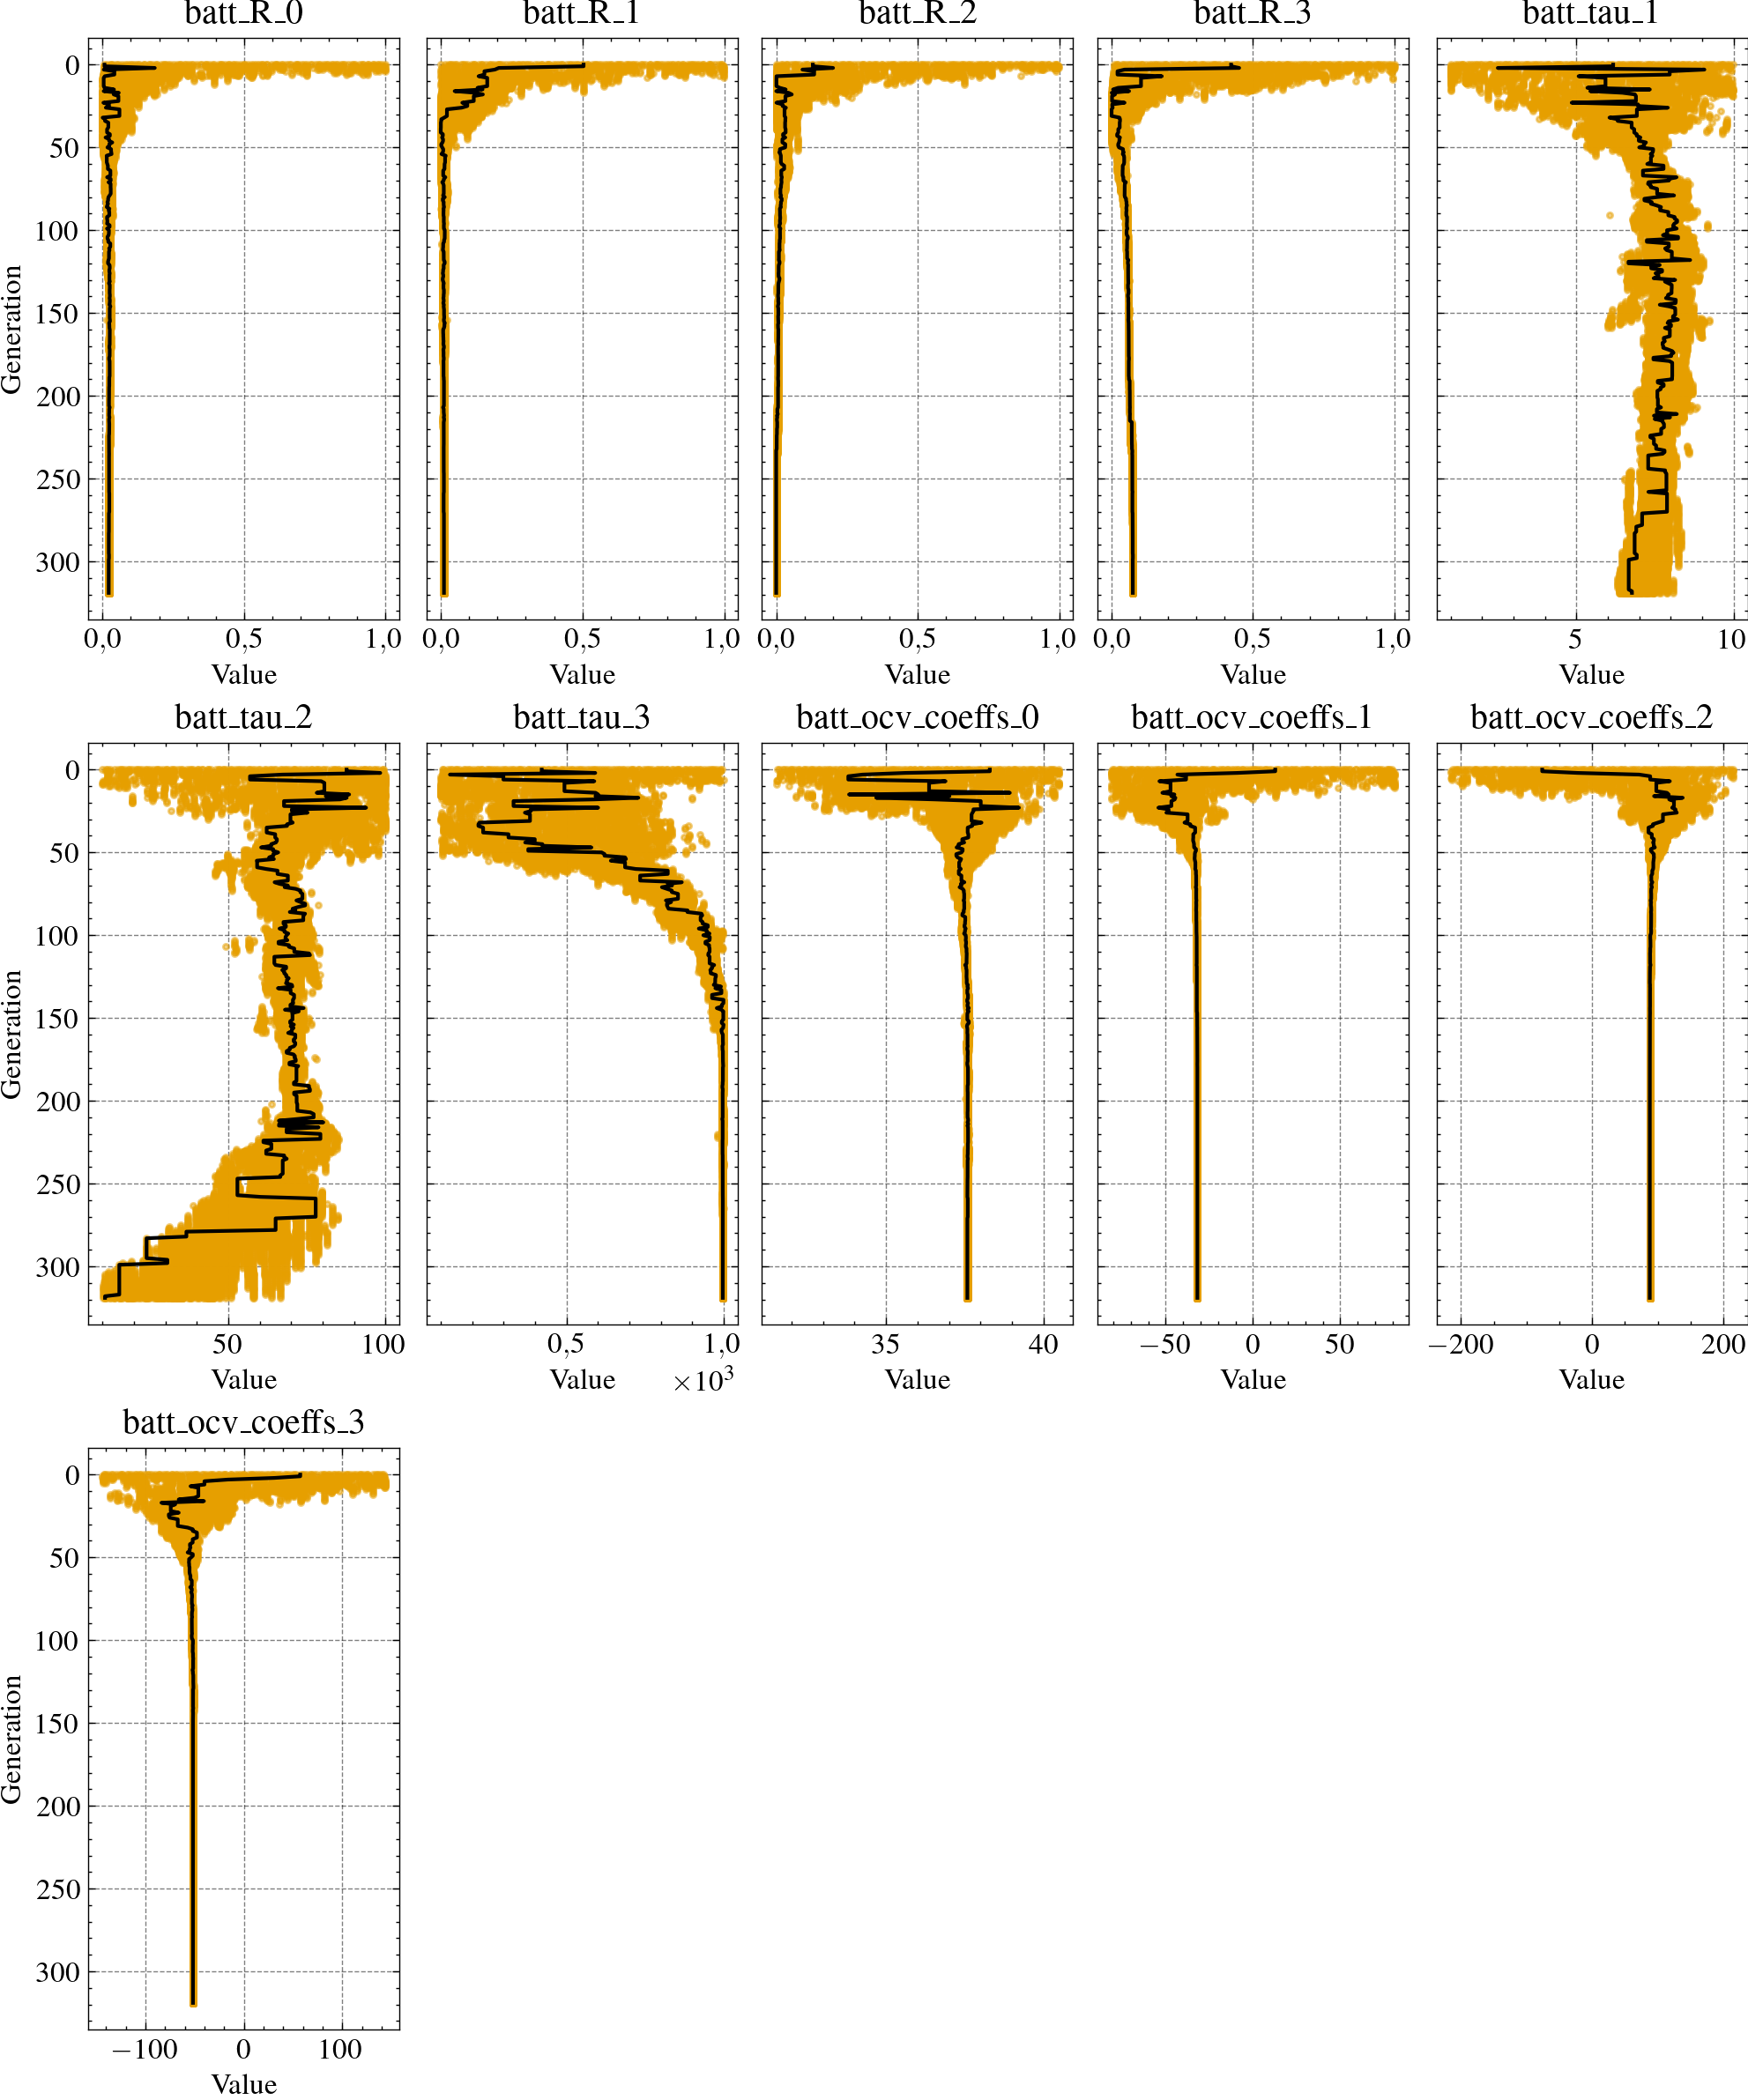

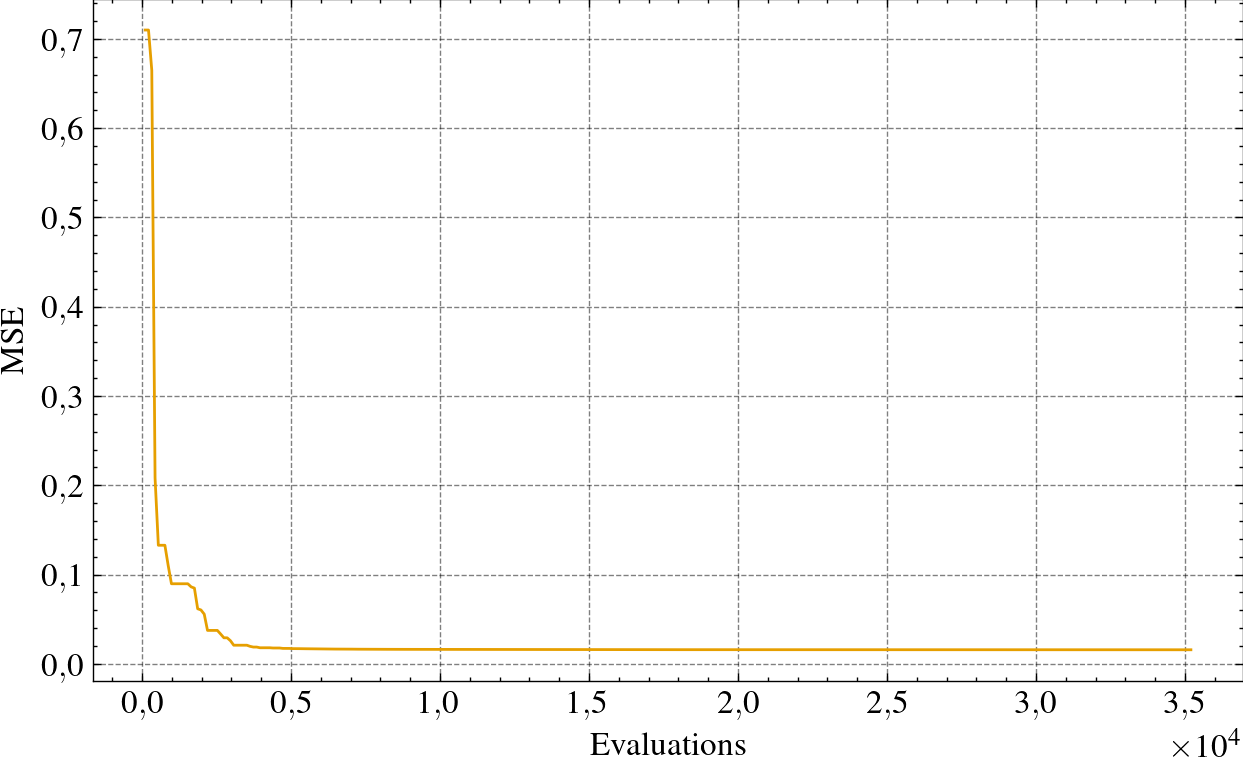

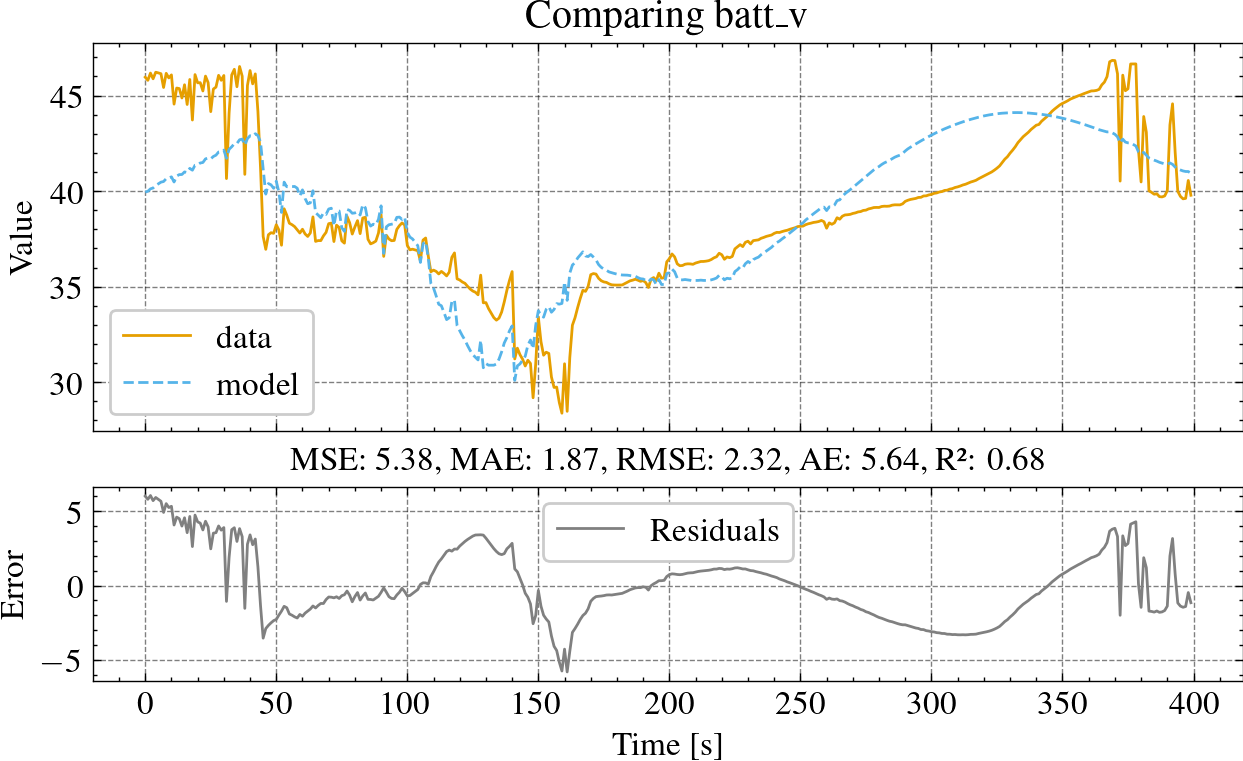

CPU times: user 16.4 s, sys: 3.93 s, total: 20.3 s
Wall time: 24min 54s


In [ ]:
%%time
## BATTERY OPTIMIZATION

# Select the optimization data
# data_cols = ['batt_v', 'batt_z']
data_cols = ['batt_v']
input_cols = ['batt_i']

# Put simulation data into df
# df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols]
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols].resample('1min').mean().interpolate(method='time')
compute_df_capacity(df_train, nominal_Q, initial_SOC, inplace=True)
compute_df_soc(df_train, nominal_Q, inplace=True)
# df_train['batt_z'] = (df_train['batt_z'] - df_train['batt_z'].min()) / (df_train['batt_z'].max() - df_train['batt_z'].min())
df_train['batt_z'] = df_train['batt_z'] - df_train['batt_z'].min()

# Set model states initial conditions
batt_z_0 = df_train['batt_z'][0]
input_initial_state = {'batt_z': batt_z_0}

# Initialize Parameters
params_bounds = {
    'batt_R_0': dict(min=1e-4, max=1),
    'batt_R_1': dict(min=1e-4, max=1),
    'batt_R_2': dict(min=1e-4, max=1),
    'batt_R_3': dict(min=1e-4, max=1),
    'batt_tau_1': dict(min=1, max=10),
    'batt_tau_2': dict(min=10, max=100),
    'batt_tau_3': dict(min=100, max=1000),
    # 'batt_eta': dict(min=0.8, max=1.0),
}
n_coeffs = 4
coeff_bounds = estimate_polynomial_coefficient_bounds(x_interval=(0, 1), y_bounds=y_bounds_estimated, degree=(n_coeffs-1))
for i in range(0, n_coeffs):
    params_bounds[f'batt_ocv_coeffs_{i}'] = dict(min=coeff_bounds[i][0], max=coeff_bounds[i][1])

# Initialize the thread pool and create the runner
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

# Initialize the problem
model = Battery
model_params = battery_params
problem = MyOptimizationProblem(
    model=model,
    model_function=model_function,
    training_data=df_train,
    training_data_columns=data_cols,
    model_params=model_params,
    opt_params_bounds=params_bounds,
    input_initial_state=input_initial_state,
    input_columns=input_cols,
    data_scaler=MinMaxScaler,
    elementwise_runner=runner,
)

algorithm = DE(
    pop_size=10*len(params_bounds),
    sampling=LHS(),
    variant="DE/rand/1/bin",
    F=0.2,
    CR=0.9,
)

# Specify termination criteria (optional)
termination = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=20,
    n_max_gen=1000,
    n_max_evals=100000
)

# Run the optimization
result = minimize(
    problem,
    algorithm,
    termination=termination,
    seed=42,
    verbose=True,
    save_history=True,
)
print('Threads:', result.exec_time)
pool.close()
pool.join()

# Print the results
best_params = convert_to_model_params({k: result.X[i] for (i, k) in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

T = df_train['t'].to_numpy()
U = df_train[input_cols].to_numpy().T
X0 = Battery.initial_state(X0={'batt_z': batt_z_0}, U0=U[:,0], params=model_params | best_params)

best_fit_data = model_function(T, U, X0, **(model_params | best_params))

for col in data_cols:
    plot_compare(df_train, best_fit_data, col)

0.7499306957631878


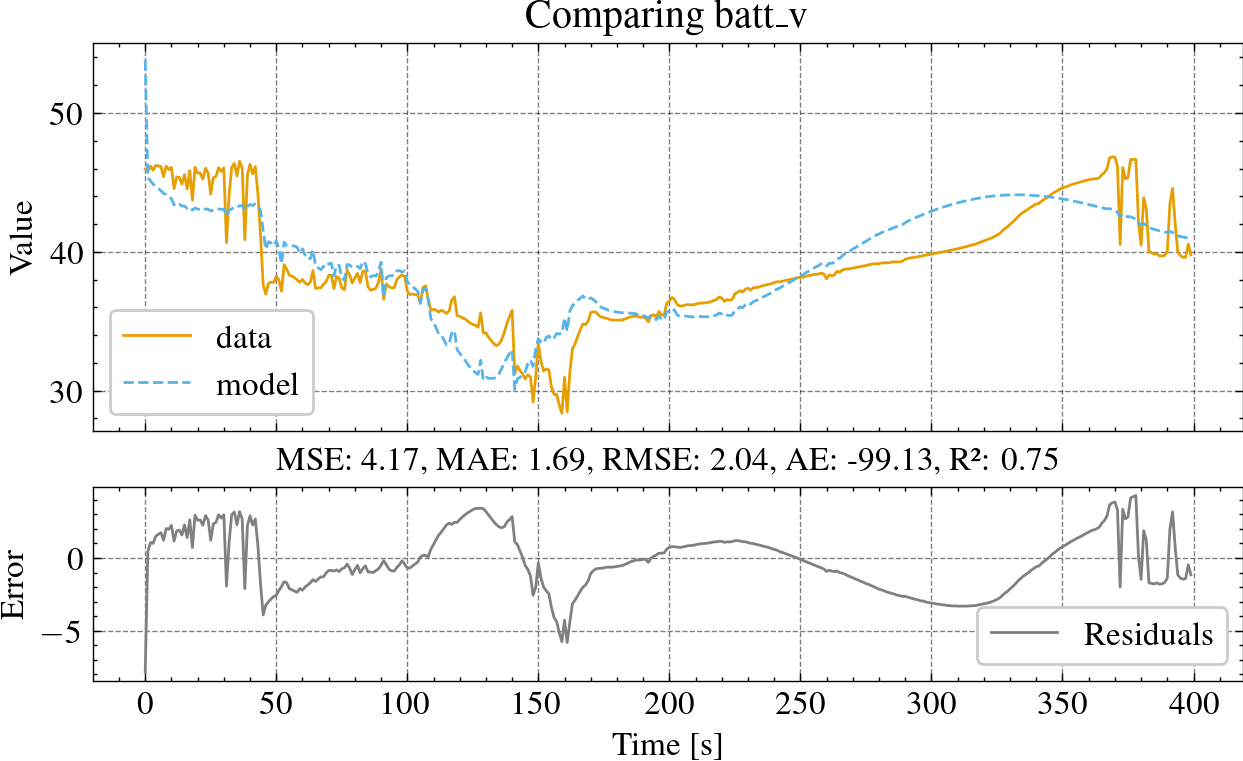

In [63]:
# best_params = {'batt_R_0': 0.007916334481399038,
#  'batt_R_1': 0.035965643206503695,
#  'batt_R_2': 0.015305594473085535,
#  'batt_R_3': 0.03578542138952177,
#  'batt_tau_1': 1.0830593397219521,
#  'batt_tau_2': 32.911208658465895,
#  'batt_tau_3': 617.117309127647,
#  'batt_k_V_OC_coeffs': [33.116704511129484,
#   18.419990227423675,
#   -17.88682284308461,
#   8.973587636098115]}
# best_params |= {'batt_k_V_OC_coeffs': batt_k_V_OC_coeffs}

T = df_train['t'].to_numpy()
U = df_train[input_cols].to_numpy().T
model_tmp = model.build({})
X0 = Battery.initial_state(X0={'batt_z': batt_z_0}, U0=U[:,0], params=battery_params)

best_fit_data = model_function(T, U, X0, **(model_params | best_params))

print(compute_metrics(df_train['batt_v'], best_fit_data['batt_v'])['R2'])

for col in data_cols:
    plot_compare(df_train, best_fit_data, col)

In [64]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination import get_termination
from pymoo.core.evaluator import Evaluator
from pymoo.parallelization.starmap import StarmapParallelization
from sklearn.metrics import mean_squared_error
import multiprocessing

class BattZOptimization(ElementwiseProblem):
    def __init__(self, section, df, nominal_Q, model_params, best_params, data_cols, input_cols, **kwargs):
        super().__init__(n_var=1, n_obj=1, n_constr=0, xl=np.array([0]), xu=np.array([1]), **kwargs)
        self.section = section
        self.df = df
        self.nominal_Q = nominal_Q
        self.model_params = model_params
        self.best_params = best_params
        self.data_cols = data_cols
        self.input_cols = input_cols

    def _evaluate(self, x, out, *args, **kwargs):
        batt_z_0 = x[0]

        df_test = self.df.loc[
            (self.df.index >= self.section['start']) & (self.df.index <= self.section['end']),
            ['t'] + self.data_cols + self.input_cols
        ].dropna().resample('1min').mean().interpolate(method='time')

        if df_test.empty:
            out["F"] = np.inf
            return

        compute_df_capacity(df_test, self.nominal_Q, batt_z_0, inplace=True)
        compute_df_soc(df_test, self.nominal_Q, inplace=True)

        T = df_test['t'].to_numpy()
        U = df_test[self.input_cols].to_numpy().T

        X0 = Battery.initial_state(X0={'batt_z': df_test['batt_z'][0]}, U0=U[:, 0], params=self.model_params | self.best_params)
        df_pred = model_function(T, U, X0, **(self.model_params | self.best_params))

        out["F"] = mean_squared_error(df_test[self.data_cols].values, df_pred[self.data_cols].values)

# Create a parallel processing pool
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

# Run optimization for each section
batt_z_0_dict = {}
for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    problem = BattZOptimization(
        section, df, nominal_Q, model_params, best_params, data_cols, input_cols, elementwise_runner=runner,
    )

    algorithm = DE(
        pop_size=10,
        sampling=LHS(),
        variant="DE/rand/1/bin",
        F=0.2,
        CR=0.9,
    )

    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=20,
        n_max_gen=10000,
        n_max_evals=100000
    )

    res = minimize(problem, algorithm, termination=termination, seed=42, verbose=True, save_history=True)

    batt_z_0_dict[section_name] = res.X[0]

    print(f'Optimized batt_z_0 for {section_name}: {res.X[0]}')

pool.close()
pool.join()

print("Final batt_z_0_dict:", batt_z_0_dict)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  6.578387E+01 |  5.6782737417
     2 |       20 |  1.675599E+01 |  5.3310899190
     3 |       30 |  9.5049152328 |  5.3310899190
     4 |       40 |  6.3229656131 |  5.3310899190
     5 |       50 |  5.5265350383 |  5.3310899190
     6 |       60 |  5.4398731239 |  5.3310899190
     7 |       70 |  5.3623831020 |  5.3310899190
     8 |       80 |  5.3402160684 |  5.3310899190
     9 |       90 |  5.3348130543 |  5.3286326230
    10 |      100 |  5.3327599056 |  5.3278353971
    11 |      110 |  5.3314672996 |  5.3278353971
    12 |      120 |  5.3300923231 |  5.3278353971
    13 |      130 |  5.3295369712 |  5.3266028496
    14 |      140 |  5.3294546413 |  5.3266028496
    15 |      150 |  5.3294332038 |  5.3266028496
    16 |      160 |  5.3292805667 |  5.3266028496
    17 |      170 |  5.3292365604 |  5.3266028496
    18 |      180 |  5.3292365604 |  5.3266028496
    19 |      190 |  5.3290727244 |  5.3266028496


{'D': 0.5746345159700506, 'E': 0.6329697586676295, 'F': 0.4853374454393353, 'F1': 0.5156548451900423, 'F2': 0.5527859010462851}
/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_d.pdf


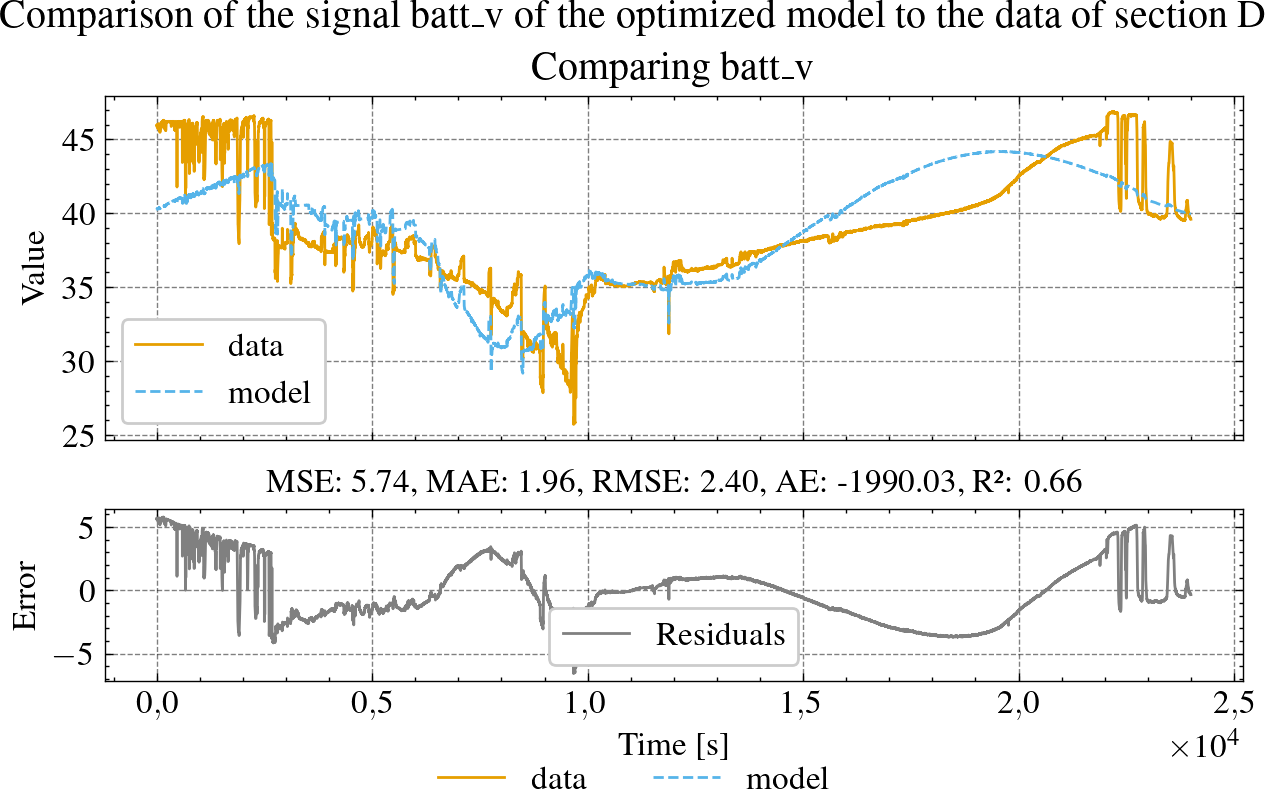

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_e.pdf


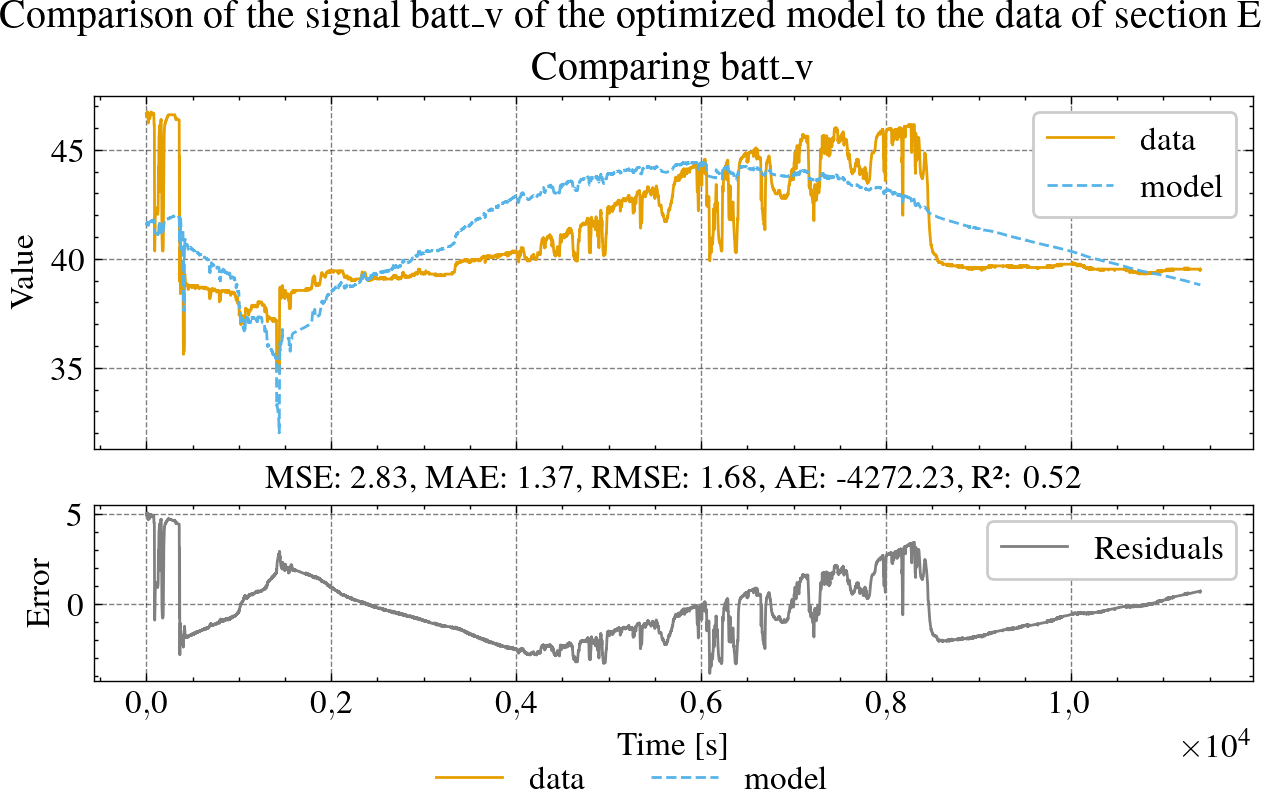

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_f.pdf


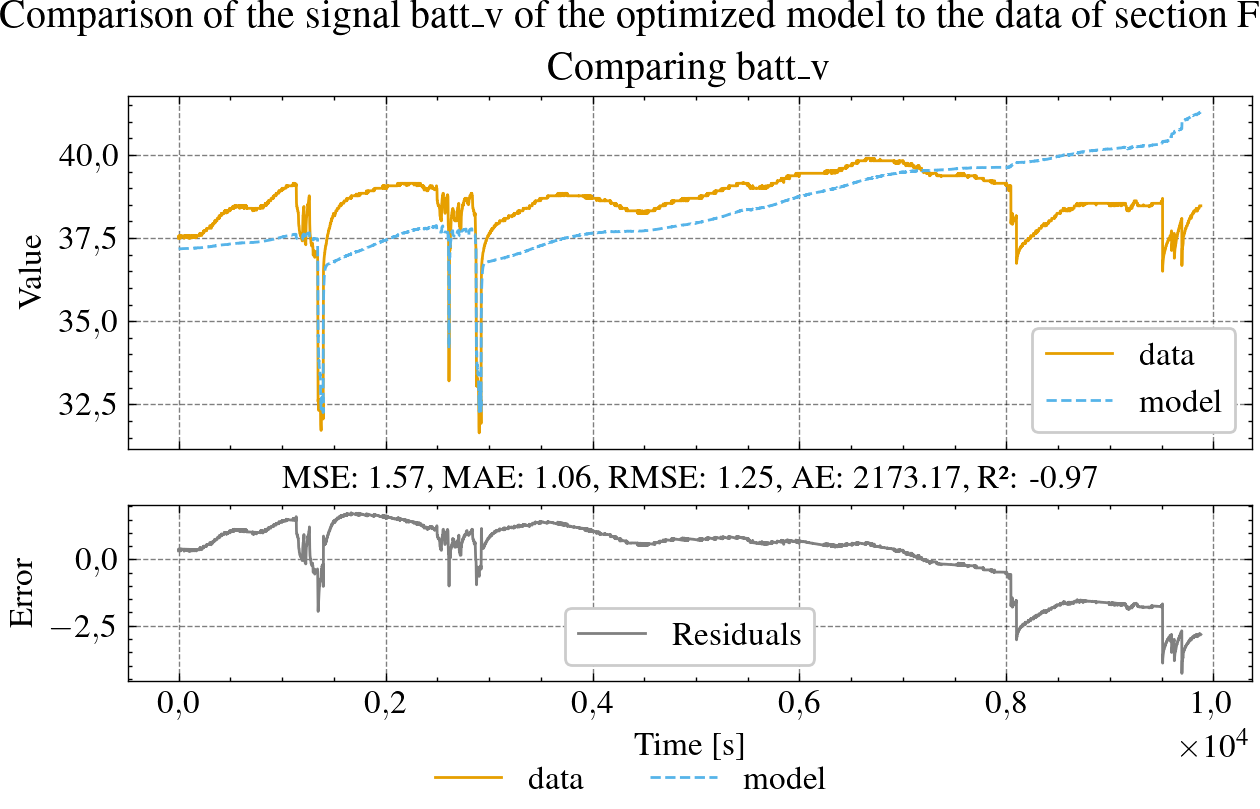

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_f1.pdf


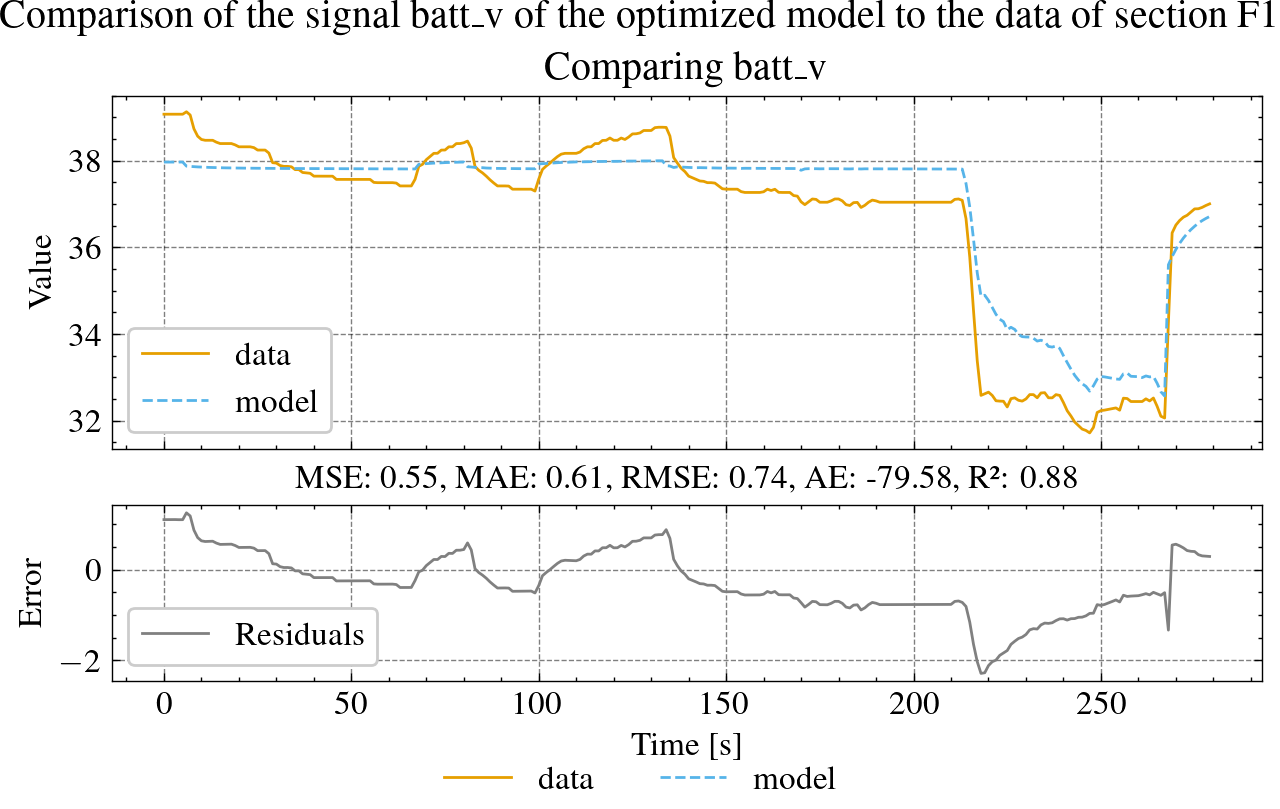

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_f2.pdf


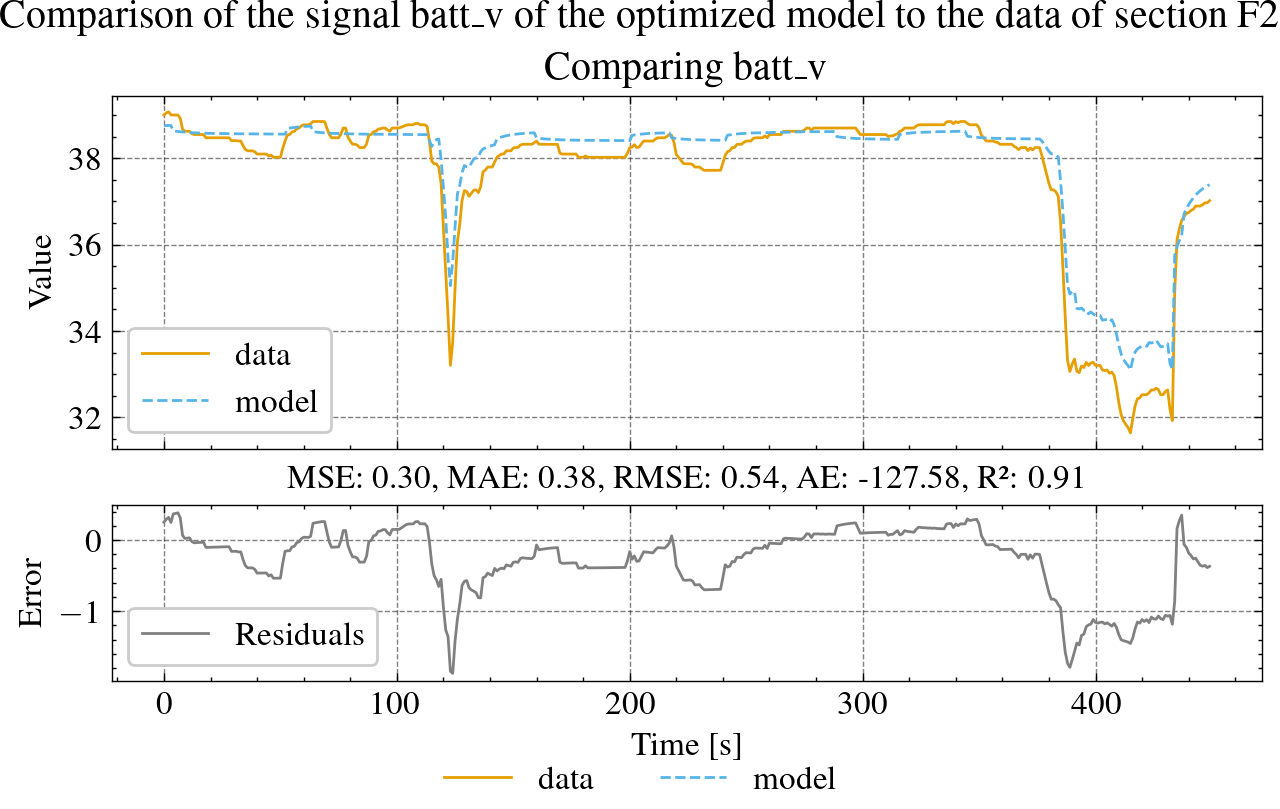

In [65]:
print(batt_z_0_dict)

for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')
    batt_z_0 = batt_z_0_dict[section_name]

    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue
    compute_df_capacity(df_test, nominal_Q, batt_z_0, inplace=True)
    compute_df_soc(df_test, nominal_Q, inplace=True)
    batt_z_0 = df_test['batt_z'][0]

    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = Battery.initial_state(X0={'batt_z': batt_z_0}, U0=U[:,0], params=model_params | best_params)

    df_pred = model_function(T, U, X0, **(model_params | best_params))

    # Plot comparison for each data column
    for col in data_cols:
        filename = f'{latex_img_path}/battery_optimization_test_residuals_{col}_test_{section_name.lower()}.pdf'
        print(filename)
        fig_save_and_show(
            filename=filename,
            show_title=f'Comparison of the signal {col} of the optimized model to the data of section {section_name}',
            save_title=f'Comparação do sinal {col} do modelo otimizado com os dados da seção {section_name}',
            ncol=2,
            fig=plot_compare(df_test, df_pred, col, show=False),
        )


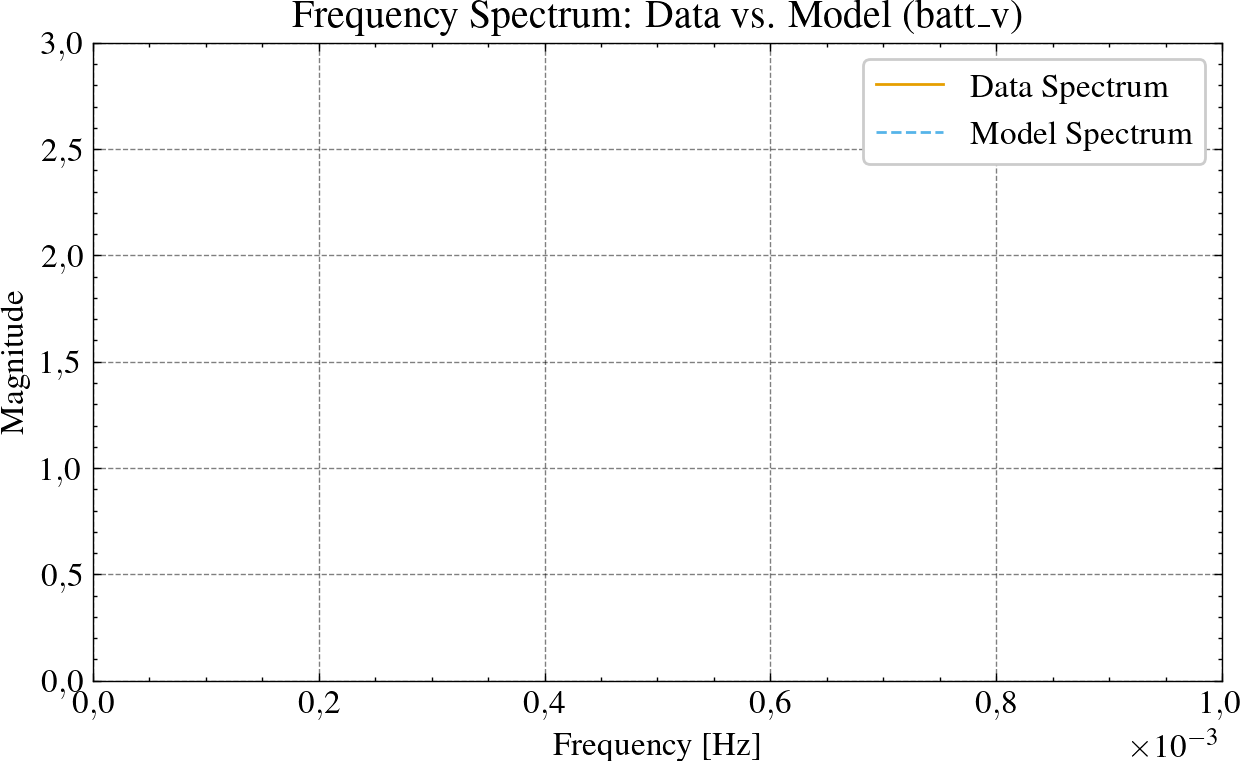

In [66]:
import numpy as np
import matplotlib.pyplot as plt

def plot_frequency_spectrum(data_series, model_series, sampling_rate, title="Frequency Spectrum Comparison"):
    """
    Plots the frequency spectrum of the data and model series.

    Args:
        data_series: Pandas Series or numpy array of the data.
        model_series: Pandas Series or numpy array of the model output.
        sampling_rate: Sampling rate of the data in Hz (or samples per unit time).
        title: Title of the plot.
    """
    n = len(data_series)
    yf_data = np.fft.fft(data_series.to_numpy()) # FFT of data
    yf_model = np.fft.fft(model_series.to_numpy()) # FFT of model
    xf = np.fft.fftfreq(n, d=1/sampling_rate)[:n//2] # Frequency axis (positive frequencies)

    fig, ax = plt.subplots()
    ax.plot(xf, 2.0/n * np.abs(yf_data[0:n//2]), label='Data Spectrum') # Plot magnitude spectrum of data
    ax.plot(xf, 2.0/n * np.abs(yf_model[0:n//2]), label='Model Spectrum') # Plot magnitude spectrum of model
    ax.set_xlabel("Frequency [Hz]") # Adjust frequency unit if your sampling rate is not in Hz
    ax.set_ylabel("Magnitude")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    ax.set_ylim([0, 3])
    ax.set_xlim([0, 1e-3])
    # plt.xscale("log")
    plt.show()

# --- Call the function after optimization and model simulation ---

sampling_rate_hz = 1

plot_frequency_spectrum(
    df_train['batt_v'],
    best_fit_data['batt_v'],
    sampling_rate=sampling_rate_hz,
    title="Frequency Spectrum: Data vs. Model (batt_v)"
)
